## Step 1: Library Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import soundfile as sf
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score

## Step 2: Global Configuration (Segmentation Locks)

In [2]:
# Paths
TEST_AUDIO_ROOT = r"E:\InstruNet-AI\data\polyphonic_test_data"
MODEL_PATH = r"E:\InstruNet-AI\saved_models\best_l2_regularized_model.h5"
SEGMENT_SAVE_ROOT = r"E:\InstruNet-AI\data\segmented_debug"

# =======================
# SEGMENTATION PARAMETERS
# =======================
TARGET_SR = 16000        # Standardized sampling rate
WINDOW_SEC = 3.0         # Segment length (chosen deliberately)
HOP_SEC = 1.5            # 50% overlap

# =======================
# FEATURE PARAMETERS
# =======================
N_MELS = 128
TARGET_FRAMES = 126

# =======================
# MODEL / TASK PARAMETERS
# =======================
NUM_CLASSES = 11
EPS = 1e-8
GLOBAL_THRESHOLD = 0.25

In [3]:
test_files = [f for f in os.listdir(TEST_AUDIO_ROOT) if f.endswith(".wav")]
print(f"Found {len(test_files)} test files.")

Found 1573 test files.


## Step 3: Class Mapping

In [4]:
class_names = [
    "cel", "cla", "flu", "gac", "gel",
    "org", "pia", "sax", "tru", "vio", "voi"
]

class_to_id = {c: i for i, c in enumerate(class_names)}
id_to_class = {i: c for c, i in class_to_id.items()}

## Step 4: Load Trained Model

In [5]:
model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,229 (4.12 MB)

 Trainable params: 1,080,267 (4.12 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

## Step 5: Audio Preprocessing Primitives

In [6]:
def stereo_to_mono(audio):
    if audio.ndim == 1:
        return audio
    return np.mean(audio, axis=0)

def peak_normalize(audio):
    peak = np.max(np.abs(audio))
    return audio / peak if peak > 0 else audio

def trim_silence(audio, thresh=0.02):
    idx = np.where(np.abs(audio) > thresh)[0]
    if len(idx) == 0:
        return audio
    return audio[idx[0]: idx[-1]]

## Step 6: Fixed-Duration Enforcement

In [7]:
def fix_duration(audio, sr=TARGET_SR, duration=WINDOW_SEC):
    target_len = int(sr * duration)
    if len(audio) > target_len:
        return audio[:target_len]
    else:
        return np.pad(audio, (0, target_len - len(audio)), mode="constant")

## Step 7: Log-Mel Spectrogram Extraction

In [8]:
def generate_log_mel(audio, sr=TARGET_SR):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        win_length=2048,
        window="hann",
        n_mels=N_MELS,
        power=2.0
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + EPS)
    return mel_db

## Step 8: Temporal Frame Alignment

In [9]:
def fix_mel_frames(mel, target_frames=TARGET_FRAMES):
    if mel.shape[1] < target_frames:
        mel = np.pad(
            mel,
            ((0, 0), (0, target_frames - mel.shape[1])),
            mode="constant"
        )
    else:
        mel = mel[:, :target_frames]
    return mel

## Step 9: Segment-Level Feature Pipeline

In [10]:
def extract_features(y, sr=TARGET_SR):
    y = stereo_to_mono(y)
    y = peak_normalize(y)
    y = trim_silence(y)
    y = fix_duration(y, sr)

    mel = generate_log_mel(y, sr)
    mel = fix_mel_frames(mel)

    return mel

## Step 10: Sliding Window Segmentation

In [11]:
def sliding_windows(y, sr):
    win_len = int(sr * WINDOW_SEC)
    hop_len = int(sr * HOP_SEC)

    for start in range(0, len(y) - win_len + 1, hop_len):
        yield y[start:start + win_len]

### (a) Directory for Storing Segments

In [12]:
os.makedirs(SEGMENT_SAVE_ROOT, exist_ok=True)

### (b) Explicit Segment Generation and Saving

In [13]:
def segment_and_store(audio_path, save_root, max_segments=10):
    """
    Segments an audio file and stores a few segments for inspection.
    """
    y, sr = librosa.load(audio_path, sr=TARGET_SR, mono=False)
    y = stereo_to_mono(y)
    y = peak_normalize(y)
    y = trim_silence(y)

    segments = []
    for i, window in enumerate(sliding_windows(y, sr)):
        if i >= max_segments:  # limit storage
            break
        seg = fix_duration(window, sr)
        segments.append(seg)

        save_path = os.path.join(
            save_root,
            f"{os.path.basename(audio_path).replace('.wav','')}_seg{i}.wav"
        )
        sf.write(save_path, seg, sr)

    return segments

### (c) Visual Inspection (Waveform + Spectrogram)

In [14]:
def visualize_segment(segment, sr, title="Segment"):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(segment, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    mel = generate_log_mel(segment, sr)
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(mel, sr=sr, x_axis="time", y_axis="mel")
    plt.title("Log-Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

### (d) Run Segmentation Demonstration on One File

Stored 10 segments for inspection


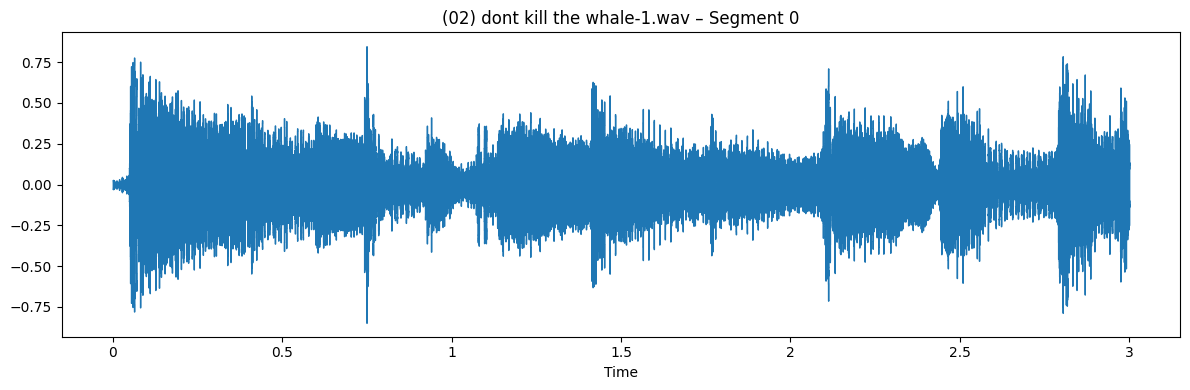

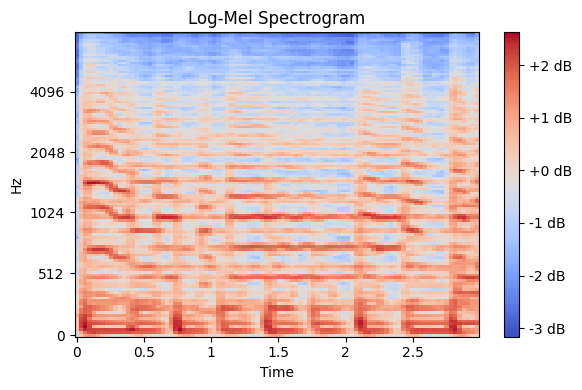

In [15]:
sample_file = test_files[0]
sample_path = os.path.join(TEST_AUDIO_ROOT, sample_file)

segments = segment_and_store(sample_path, SEGMENT_SAVE_ROOT)

print(f"Stored {len(segments)} segments for inspection")

visualize_segment(
    segments[0],
    TARGET_SR,
    title=f"{sample_file} – Segment 0"
)

## Step 11: Track-Level Prediction via Segment Aggregation

In [16]:
def predict_track(audio_path):
    y, sr = librosa.load(audio_path, sr=TARGET_SR, mono=False)
    y = stereo_to_mono(y)

    window_probs = []

    for window in sliding_windows(y, sr):
        mel = extract_features(window, sr)
        mel = mel[..., np.newaxis]
        mel = mel[np.newaxis, ...]

        probs = model.predict(mel, verbose=0)[0]
        window_probs.append(probs)

    window_probs = np.array(window_probs)

    # Temporal aggregation
    return window_probs.mean(axis=0)

## Step 12: Ground Truth Loader (Multi-Label)

In [17]:
def load_multilabel_gt(txt_path):
    labels = np.zeros(NUM_CLASSES)
    with open(txt_path, "r") as f:
        instruments = f.read().strip().split("\n")
        for inst in instruments:
            if inst in class_to_id:
                labels[class_to_id[inst]] = 1
    return labels

## Step 13: Thresholding Strategy

In [18]:
def apply_global_threshold(probs, threshold=GLOBAL_THRESHOLD):
    return (probs >= threshold).astype(int)

## Step 14: Full Test Inference Pipeline

In [19]:
test_files = [f for f in os.listdir(TEST_AUDIO_ROOT) if f.endswith(".wav")]
print("Number of test files:", len(test_files))

y_test_true = []
y_test_pred = []

for wav in tqdm(test_files, desc="Test inference"):
    audio_path = os.path.join(TEST_AUDIO_ROOT, wav)
    txt_path = audio_path.replace(".wav", ".txt")

    gt = load_multilabel_gt(txt_path)
    probs = predict_track(audio_path)
    pred = apply_global_threshold(probs)

    y_test_true.append(gt)
    y_test_pred.append(pred)

y_test_true = np.stack(y_test_true)
y_test_pred = np.stack(y_test_pred)

Number of test files: 1573


Test inference: 100%|██████████████████████████████████████████████████████████████| 1573/1573 [58:40<00:00,  2.24s/it]


## Step 15: Evaluation

In [20]:
print("Global Threshold:", GLOBAL_THRESHOLD)
print("Micro F1 :", f1_score(y_test_true, y_test_pred, average="micro"))
print("Macro F1 :", f1_score(y_test_true, y_test_pred, average="macro"))

print(classification_report(
    y_test_true,
    y_test_pred,
    target_names=class_names,
    zero_division=0
))

Global Threshold: 0.25
Micro F1 : 0.6365105008077544
Macro F1 : 0.416751464366757
              precision    recall  f1-score   support

         cel       0.00      0.00      0.00         0
         cla       0.19      0.26      0.22        23
         flu       0.00      0.00      0.00         4
         gac       0.64      0.78      0.70       119
         gel       0.30      0.35      0.32       145
         org       0.25      0.31      0.28        77
         pia       0.84      0.64      0.73       326
         sax       0.74      0.74      0.74       185
         tru       0.52      0.26      0.34       109
         vio       0.48      0.30      0.37       102
         voi       0.92      0.84      0.88       483

   micro avg       0.65      0.63      0.64      1573
   macro avg       0.44      0.41      0.42      1573
weighted avg       0.70      0.63      0.65      1573
 samples avg       0.57      0.63      0.59      1573

